In [1]:
import numpy as np
import pandas as pd
import operator
import random
import math
from functools import partial
from deap import gp, base, creator, tools, algorithms
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [2]:
PATH_TRAIN = "./data/train.csv"
PATH_TEST = "./data/test.csv"

DTYPES_FEATURES = {
          "id": "uint64",
          "fr_COO": "category",
          "fr_COO2": "category",
      }

DTYPES_TARGETS = {
          "EC1": "bool",
          "EC2": "bool",
          "EC3": "bool",
          "EC4": "bool",
          "EC5": "bool",
          "EC6": "bool"
}

DROP_COLS = ["EC3", "EC4", "EC5", "EC6"]



def _load_data(datapath: str, dtypes: dict, drop_cols: list) -> pd.DataFrame:
  return pd.read_csv(
      filepath_or_buffer=datapath,
      dtype=dtypes,
      index_col="id"
    ).drop(columns=drop_cols, axis=1)


GetTrainDF = partial(_load_data, datapath=PATH_TRAIN, dtypes=dict(**DTYPES_TARGETS, **DTYPES_FEATURES), drop_cols=DROP_COLS)
GetTestDF = partial(_load_data, datapath=PATH_TEST, dtypes=DTYPES_FEATURES, drop_cols=[])

df_test = GetTestDF().astype(float)
df_train = GetTrainDF().astype(float)
df_train

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
id,,,,,,,,,,,,,,,,,,,,,
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0.0,0.0,1.0,1.0
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0.0,0.0,0.0,1.0
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0.0,0.0,1.0,1.0
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0.0,0.0,1.0,1.0
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,632.207041,10.911303,6.579933,9.179964,4.653583,6.030052,3.670528,1.770579,32.971529,6.606882,...,13.847474,6.923737,34.407699,32.607024,18.947452,61.376610,0.0,0.0,1.0,1.0
14834,62.568425,2.642734,1.446898,1.446898,0.879497,0.879497,0.174620,0.000000,0.000000,0.000000,...,0.000000,6.066367,0.000000,6.420822,0.000000,10.000000,0.0,0.0,0.0,1.0
14835,981.327476,10.363081,6.146219,6.146219,4.700576,4.700576,3.064846,2.133897,17.248535,0.000000,...,0.000000,23.762553,10.969244,0.000000,0.000000,66.666667,0.0,0.0,1.0,1.0


In [3]:
# names (=argn) and number (=argc) of arguments

argn = df_train.drop(columns=["EC1", "EC2"], inplace=False).columns.to_list()
argc = len(argn)

In [4]:
pset = gp.PrimitiveSet("MAIN", arity=argc, prefix="ARG")

pset.renameArguments(**{f"ARG{i}": arg for i, arg in enumerate(argn)})

def protectedDiv(left: float, right: float) -> float:
    if right == 0:
        return 1
    else:
         return left / right
    
def if_lt(a: float, b: float, c: float, d: float) -> float:
    if a < b:
        return c
    else:
        return d
    
pset.addPrimitive(if_lt, 4, name="if_lt")
pset.addPrimitive(protectedDiv, 2, name="div")
pset.addPrimitive(operator.add, 2, name="add")
pset.addPrimitive(operator.sub, 2, name="sub")
pset.addPrimitive(operator.mul, 2, name="mul")
pset.addPrimitive(operator.neg, 1, name="neg")
pset.addPrimitive(math.cos, 1, name="cos")
pset.addPrimitive(math.sin, 1, name="sin")
pset.addPrimitive(math.tanh, 1, name="tanh")
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [5]:
# create a fitness and individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [6]:
# create a toolbox

toolbox_ec1 = base.Toolbox()
toolbox_ec2 = base.Toolbox()


In [7]:
# create a X and y

X = df_train.drop(columns=["EC1", "EC2"], inplace=False).values
y_ec1 = df_train["EC1"].values.astype(int)
y_ec2 = df_train["EC2"].values.astype(int)


In [8]:

def get_proba(individual: str, X: np.ndarray, pset: gp.PrimitiveSet=pset) -> np.ndarray:
    """Get the probabilities of the positive class for each sample in X"""
    func = gp.compile(expr=individual, pset=pset)
    y_pred_vals = np.array([func(*x) for x in X])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(y_pred_vals.reshape(-1, 1))
    y_pred_probs = scaler.transform(y_pred_vals.reshape(-1, 1)).reshape(-1)

    return y_pred_probs

def get_pred(individual: str, X: np.ndarray, pset: gp.PrimitiveSet=pset) -> np.ndarray:
    """Get the predicted class for each sample in X"""
    y_pred_probs = get_proba(individual, X, pset=pset)
    y_pred = np.where(y_pred_probs > 0.5, 1, 0)
    
    return y_pred

def evalBinaryClassification(individual: str, X: np.ndarray, y: np.ndarray, pset: gp.PrimitiveSet=pset):
    """fitness function that takes an individual, X and y as input and returns the corresponding auc score"""
    y_pred_probs = get_proba(individual, X, pset=pset)
    return roc_auc_score(y, y_pred_probs),


In [9]:
# set up the toolbox for the gp algorithm on the ec1 target

toolbox_ec1.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec1.register("individual", tools.initIterate, creator.Individual, toolbox_ec1.expr)
toolbox_ec1.register("population", tools.initRepeat, list, toolbox_ec1.individual)


toolbox_ec1.register("select", tools.selTournament, tournsize=2)
toolbox_ec1.register("mate", gp.cxOnePoint)
toolbox_ec1.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec1.register("mutate", gp.mutUniform, expr=toolbox_ec1.expr_mut, pset=pset)
toolbox_ec1.register("compile", gp.compile, pset=pset)
toolbox_ec1.register("evaluate", evalBinaryClassification, X=X, y=y_ec1)

# bloat control
toolbox_ec1.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec1.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

# set up the toolbox for the gp algorithm on the ec2 target

toolbox_ec2.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox_ec2.register("individual", tools.initIterate, creator.Individual, toolbox_ec2.expr)
toolbox_ec2.register("population", tools.initRepeat, list, toolbox_ec2.individual)


toolbox_ec2.register("select", tools.selTournament, tournsize=2)
toolbox_ec2.register("mate", gp.cxOnePoint)
toolbox_ec2.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox_ec2.register("mutate", gp.mutUniform, expr=toolbox_ec2.expr_mut, pset=pset)
toolbox_ec2.register("compile", gp.compile, pset=pset)
toolbox_ec2.register("evaluate", evalBinaryClassification, X=X, y=y_ec2)

toolbox_ec2.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)
toolbox_ec2.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17)
)

In [10]:
# statistics dictionary
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


In [11]:
# run the algorithm on the ec1 target

# evolutionary parameters
NGEN_EC1 = 100
POPSIZE_EC1 = 1200
CXPB_EC1 = 0.9
MUTPB_EC1 = 0.1

pop_ec1 = toolbox_ec1.population(n=POPSIZE_EC1)
hof_ec1 = tools.HallOfFame(1)


pop_ec1, log_ec1 = algorithms.eaSimple(pop_ec1, toolbox_ec1, CXPB_EC1, MUTPB_EC1, NGEN_EC1, stats=stats, halloffame=hof_ec1, verbose=True)

# save the winner program as a string in lisp format
try:
    f_ec1_raw = hof_ec1[0]
    print(f_ec1_raw)
except IndexError:
    print("No program found for EC1")
    f_ec1_raw = None

gen	nevals	avg     	std      	min    	max     
0  	1200  	0.489535	0.0699798	0.34599	0.656641


In [ ]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness

try:
    gen_ec1 = log_ec1.select("gen") 
    fit_avgs_ec1 = log_ec1.select("avg")
    fit_maxs_ec1 = log_ec1.select("max")

    fig, ax1 = plt.subplots()
    line2 = ax1.plot(gen_ec1, fit_avgs_ec1, "r-", label="Average")
    line3 = ax1.plot(gen_ec1, fit_maxs_ec1, "g-", label="Maximum")

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("ROC AUC Score")

    ax1.set_title("EC1 - Evolution of the fitness over generations")

    ax1.legend()


    plt.show()
except NameError:
    print("No logbook found for EC1")

No logbook found for EC1


In [ ]:
# run the algorithm on the ec2 target

# evolutionary parameters
NGEN_EC2 = 100
POPSIZE_EC2 = 1200
CXPB_EC2 = 0.9
MUTPB_EC2 = 0.1

pop_ec2 = toolbox_ec2.population(n=POPSIZE_EC2)
hof_ec2 = tools.HallOfFame(1)


pop_ec2, log_ec2 = algorithms.eaSimple(pop_ec2, toolbox_ec2, CXPB_EC2, MUTPB_EC2, NGEN_EC2, stats=stats, halloffame=hof_ec2, verbose=True)

# save the winner program as a "string in lisp format
try:
    f_ec2_raw = hof_ec2[0]
    print(f_ec2_raw)
except IndexError:
    print("No program found for EC2")
    f_ec2_raw = None

gen	nevals	avg     	std      	min     	max    
0  	500   	0.499738	0.0198746	0.446773	0.55461
1  	466   	0.505357	0.0190115	0.431903	0.553066
2  	452   	0.508114	0.0202247	0.440621	0.553763
3  	455   	0.511091	0.0208762	0.449506	0.560481
4  	472   	0.511906	0.0223827	0.431464	0.560481
5  	443   	0.513261	0.0222489	0.446407	0.560481
6  	458   	0.51436 	0.0251687	0.439048	0.567203
7  	442   	0.520753	0.0228605	0.44675 	0.567203
8  	442   	0.521444	0.0253352	0.44899 	0.567203
9  	451   	0.52454 	0.0256378	0.448594	0.567203
10 	463   	0.526415	0.0259293	0.433122	0.562916
11 	441   	0.531114	0.0249583	0.445194	0.56533 
12 	462   	0.533616	0.0243668	0.44471 	0.563817
13 	444   	0.535136	0.025586 	0.446216	0.563381
14 	447   	0.538168	0.0226266	0.449302	0.563381
15 	464   	0.54081 	0.0207725	0.449302	0.563534
16 	441   	0.540441	0.0231083	0.445705	0.563293
17 	449   	0.542799	0.0216497	0.447115	0.563762
18 	443   	0.545535	0.0183053	0.446526	0.565772
19 	450   	0.546829	0.0184898	0.449302	0.5

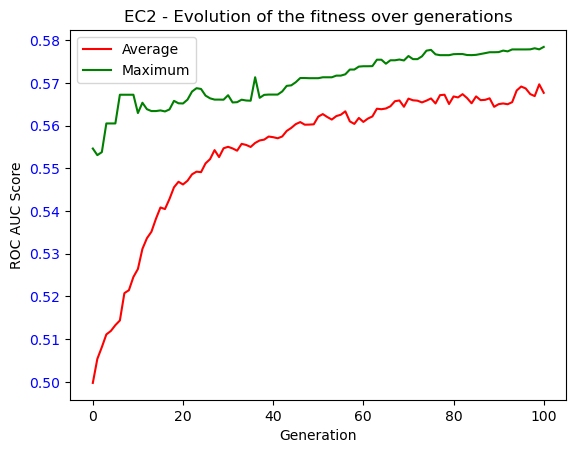

In [ ]:
# plot the evolution from the logbook log_ec1
# plot the average, max and std deviation of fitness

try:
    gen_ec2 = log_ec2.select("gen") 
    fit_avgs_ec2 = log_ec2.select("avg")
    fit_maxs_ec2 = log_ec2.select("max")

    fig, ax1 = plt.subplots()
    line2 = ax1.plot(gen_ec2, fit_avgs_ec2, "r-", label="Average")
    line3 = ax1.plot(gen_ec2, fit_maxs_ec2, "g-", label="Maximum")

    ax1.set_xlabel("Generation")
    ax1.set_ylabel("ROC AUC Score")

    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax1.set_title("EC2 - Evolution of the fitness over generations")
    ax1.legend()

    plt.show()
except NameError:
    print("No logbook found for EC2")



In [ ]:
# predict the labels for the test set

X = df_test.to_numpy()

# ec1
if f_ec1_raw is not None:
    ec1_pred = get_proba(f_ec1_raw, X, pset=pset)

# ec2
if f_ec2_raw is not None:
    ec2_pred = get_proba(f_ec2_raw, X, pset=pset)

# save the predictions in a csv file
try:
    df_result = pd.DataFrame({"id": df_test.index.values, "ec1": ec1_pred, "ec2": ec2_pred})

    df_result.to_csv("results.csv", index=False)
except NameError:
    print("No predictions found")

# EC1 - Hall of Fame


```{lisp}
mul(sub(mul(if_lt(neg(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(div(if_lt(div(HallKierAlpha, fr_COO2), mul(ExactMolWt, neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(ExactMolWt, Chi1), sub(NumHeteroatoms, FpDensityMorgan1), neg(NumHeteroatoms))), BertzCT), sub(ExactMolWt, tanh(mul(BertzCT, cos(neg(HallKierAlpha))))), sub(if_lt(tanh(Kappa3), neg(add(Chi1, if_lt(sub(tanh(NumHeteroatoms), cos(add(NumHeteroatoms, PEOE_VSA8))), EState_VSA1, sub(div(div(ExactMolWt, EState_VSA1), Chi2v), Kappa3), cos(Chi2n)))), MinEStateIndex, ExactMolWt), Chi1n), div(SlogP_VSA3, cos(Chi2v)))), SMR_VSA10))), div(SlogP_VSA3, div(MinEStateIndex, sin(MinEStateIndex))), VSA_EState9, tanh(Kappa3)), MinEStateIndex), if_lt(if_lt(PEOE_VSA14, Chi4n, sin(PEOE_VSA14), Chi1), neg(add(div(div(ExactMolWt, Chi2v), Chi1), sub(Chi4n, mul(if_lt(sin(Chi2n), neg(PEOE_VSA8), HallKierAlpha, PEOE_VSA14), Chi1v)))), cos(EState_VSA1), PEOE_VSA10)), if_lt(div(HallKierAlpha, neg(add(div(FpDensityMorgan1, Chi2v), sub(Chi4n, if_lt(Chi2v, sub(if_lt(tanh(tanh(Kappa3)), add(div(ExactMolWt, Chi2v), if_lt(sub(tanh(SMR_VSA10), sin(EState_VSA2)), sub(if_lt(tanh(Kappa3), Chi3v, Chi1, FpDensityMorgan1), EState_VSA1), Chi2v, cos(Chi2n))), Chi1, ExactMolWt), mul(BertzCT, MinEStateIndex)), sub(Chi1, Kappa3), mul(if_lt(HallKierAlpha, VSA_EState9, Chi2n, EState_VSA1), neg(FpDensityMorgan1))))))), mul(mul(mul(HallKierAlpha, fr_COO2), neg(PEOE_VSA14)), neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(ExactMolWt, Chi1), if_lt(div(HallKierAlpha, neg(add(div(FpDensityMorgan1, neg(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(sin(MinEStateIndex), sub(Chi2v, div(SlogP_VSA3, BertzCT)), sub(ExactMolWt, Chi1n), div(mul(BertzCT, MinEStateIndex), sub(NumHeteroatoms, div(Chi1v, MinEStateIndex))))), SMR_VSA10)))), sub(Chi4n, if_lt(Chi2v, sub(if_lt(tanh(Kappa3), add(div(ExactMolWt, Chi2v), if_lt(sub(tanh(SMR_VSA10), sin(EState_VSA2)), tanh(SlogP_VSA3), Chi2v, cos(Chi2n))), Chi1, ExactMolWt), EState_VSA1), sub(Chi1, Kappa3), mul(if_lt(HallKierAlpha, VSA_EState9, Chi2n, EState_VSA1), neg(FpDensityMorgan1))))))), mul(ExactMolWt, neg(FpDensityMorgan1)), NumHeteroatoms, if_lt(div(SlogP_VSA3, BertzCT), sub(add(div(ExactMolWt, Chi2v), sub(tanh(if_lt(div(if_lt(div(HallKierAlpha, EState_VSA1), mul(NumHeteroatoms, neg(FpDensityMorgan1)), NumHeteroatoms, Chi4n), BertzCT), sub(Chi2v, tanh(mul(BertzCT, cos(neg(HallKierAlpha))))), sub(ExactMolWt, Kappa3), div(SlogP_VSA3, cos(FpDensityMorgan3)))), SMR_VSA10)), Chi1), sub(NumHeteroatoms, FpDensityMorgan1), SMR_VSA10)), SMR_VSA10)))
```

*ROC_AUC_SCORE=0.68849*

# EC2 - Hall of Fame

```{lisp}
sin(div(div(if_lt(EState_VSA1, mul(VSA_EState9, div(SMR_VSA10, if_lt(fr_COO, VSA_EState9, fr_COO, fr_COO))), sub(NumHeteroatoms, VSA_EState9), sin(tanh(EState_VSA1))), if_lt(fr_COO, add(mul(add(tanh(sin(HallKierAlpha)), fr_COO), fr_COO), sub(mul(VSA_EState9, div(mul(MinEStateIndex, tanh(Chi1v)), div(sin(if_lt(MinEStateIndex, SMR_VSA10, SlogP_VSA3, fr_COO)), Chi1v))), fr_COO)), fr_COO, add(tanh(PEOE_VSA6), PEOE_VSA6))), if_lt(if_lt(cos(div(add(add(EState_VSA1, mul(if_lt(Chi2v, Chi4n, MaxAbsEStateIndex, SMR_VSA5), fr_COO)), sub(div(if_lt(tanh(PEOE_VSA10), sin(if_lt(MinEStateIndex, FpDensityMorgan3, SlogP_VSA3, fr_COO)), sin(HallKierAlpha), sin(tanh(MinEStateIndex))), Chi1v), sub(div(SMR_VSA10, SMR_VSA10), SMR_VSA5))), if_lt(cos(mul(SMR_VSA10, fr_COO)), add(tanh(FpDensityMorgan2), sub(EState_VSA1, PEOE_VSA14)), fr_COO, fr_COO))), add(MinEStateIndex, sub(div(SMR_VSA10, tanh(add(EState_VSA1, mul(SMR_VSA10, fr_COO)))), PEOE_VSA6)), cos(div(add(PEOE_VSA6, if_lt(div(mul(div(mul(mul(tanh(VSA_EState9), sub(-1, Chi2v)), tanh(MinEStateIndex)), neg(FpDensityMorgan2)), PEOE_VSA6), SMR_VSA10), sin(Chi3v), sin(PEOE_VSA7), tanh(Chi4n))), if_lt(div(mul(tanh(PEOE_VSA6), div(sin(if_lt(MinEStateIndex, FpDensityMorgan3, SlogP_VSA3, fr_COO)), fr_COO)), mul(FpDensityMorgan3, fr_COO)), add(tanh(SMR_VSA10), if_lt(if_lt(PEOE_VSA10, HallKierAlpha, SMR_VSA5, fr_COO), add(fr_COO, fr_COO), mul(VSA_EState9, mul(tanh(mul(fr_COO, div(cos(SMR_VSA10), fr_COO))), MinEStateIndex)), fr_COO)), fr_COO, sin(SMR_VSA10)))), VSA_EState9), neg(FpDensityMorgan2), fr_COO, VSA_EState9)))
```

*ROC_AUC_SCORE=0.578397*